# This notebook reads and processes .mat files from Graf 2011, computes spike counts per trial and plots tuning curves.

In [316]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [317]:
def read_data(file_path):
    '''Read and process mat file from Graf2011
    
    param array_number: {1, 2, 3, 4, 5}

    return:
        spike_times: {Nx3600} N simultaneously recorded spike trains for 3600 trials
            (50 repeated trials of 72 direction in random order)
        orientation_per_trial: orientation for each trial (of length 3600)
        num_neurons: number of neurons
        orientations: sorted set of orientations
        num_repeats: number of repeats for each (orientation,neuron) (=50)
        num_trials: 50 repeated trials x 72 directions
        trial_length: length of trial (in seconds)
    '''
    dataStruct = scipy.io.loadmat(file_path)
    spike_times = pd.DataFrame.from_dict(mat['spk_times'])
    orientation_per_trial = mat['ori'][0]
    num_neurons = np.shape(mat['neur_param'])[0]
    orientations = np.sort(np.unique(mat['ori']))
    trial_length = 2560e-3
    num_repeats = 50
    num_trials = 3600 # 50 repeated trials x 72 directions
    num_orientations = len(orientations)
    return spike_times, orientation_per_trial, num_neurons, orientations, trial_length, num_repeats, num_trials, num_orientations

In [318]:
def compute_spike_counts(spike_times, num_neurons, num_trials):
    '''
        Compute spike counts for each (orientation, neuron, trial)
        return 3D numpy array: orientation x neuron x trial
        
        TODO: add option to average [0 180] with responses from [180 360]
    '''
    spike_times_mat = spike_times.as_matrix()
    spike_counts = np.zeros((num_orientations, num_neurons, num_repeats))
    # for each orientation
    for i in range(num_orientations):
        # access indices in spike times that corresponds to ori
        idx = np.where(orientation_per_trial == orientations[i])[0]
        spike_times_ori = np.take(spike_times_mat, idx, axis = 1)
        for j in range(num_neurons):
            for k in range(num_repeats):
                spike_counts[i, j, k] = np.count_nonzero(spike_times_ori[j][k])
    return spike_counts

In [319]:
def normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats):
    '''
        Normalize by variance of spike counts
    '''
    spike_counts_norm = np.zeros((num_orientations, num_neurons, num_repeats))
    for i in range(num_repeats):
        variance_sum = np.sum(spike_counts[:, :, i]**2, axis = 1)
        spike_counts_norm[:, :, i] = (spike_counts[:, :, i]**2) / variance_sum.reshape(-1,1)
    return spike_counts_norm

In [320]:
def compute_mean_tc(spike_counts_norm):
    return np.mean(spike_counts_norm, axis=2)

def compute_var_tc(spike_counts_norm):
    return np.var(spike_counts_norm, axis=2)

def compute_cov_tc(spike_counts_norms):
    tc_cov = np.zeros((num_neurons, num_neurons, num_orientations))
    for i in range(num_orientations):
        tc_cov[:, :, i] = np.cov(spike_counts_norm[i])
    return tc_cov

In [321]:
def filter_to_well_tuned_neurons(mean_tc):
    maxdiff = np.max(mean_tc, axis=0) - np.min(mean_tc, axis=0)
    ind_tuned = np.where(maxdiff > 12)[0]
    return ind_tuned

In [322]:
# path to mat file from Graf 2011
file_path = '../../data/graf_V1data/array_1.mat'

# read and process data
spike_times, orientation_per_trial, num_neurons, orientations, trial_length,\
    num_repeats, num_trials, num_orientations = read_data(file_path)

# compute spike counts
spike_counts = compute_spike_counts(spike_times, num_neurons, num_trials)

# compute tuning curves
mean_tc = compute_mean_tc(spike_counts)
var_tc = compute_var_tc(spike_counts)
cov_tc = compute_cov_tc(spike_counts)

# identify indices for well-tuned neurons
ind_well_tuned = filter_to_well_tuned_neurons(mean_tc)

# normalize spike counts
spike_counts_norm = normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats)

# compute normalized tuning curves
mean_tc = compute_mean_tc(spike_counts_norm)
var_tc = compute_var_tc(spike_counts_norm)
cov_tc = compute_cov_tc(spike_counts_norm)

In [327]:
mean_tc.shape

(72, 147)

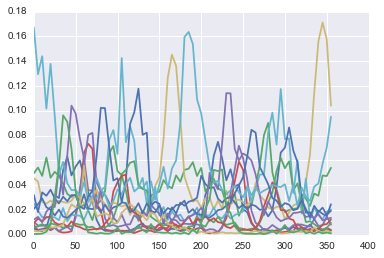

In [329]:
# plot mean tuning curve for well tuned neurons
%matplotlib inline
sns.set_style("darkgrid")
plt.plot(orientations, mean_tc[:, ind_well_tuned]);

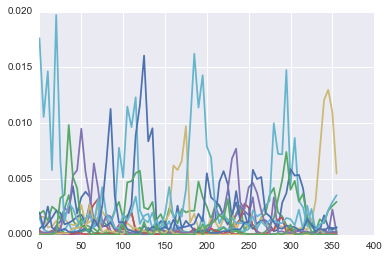

In [330]:
# plot variance tuning curve
plt.plot(orientations, var_tc[:, ind_well_tuned]);